## Pre-trained-Models with PyTorch

Here I used a pre-trained model, resnet18, to classify between the negative and positive samples.

## Download Data

In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2020-08-20 15:02:32--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

100%[====================================>] 2,598,656,062 39.3MB/s   in 68s    

2020-08-20 15:03:40 (36.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2020-08-20 15:06:34--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

100%[====================================>] 2,111,408,108 37.3MB/s   in 53s    

2020-08-20 15:07:28 (37.9 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



In [4]:
!pip install torchvision

     |████████████████████████████████| 5.9MB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 748.8MB 16kB/s s eta 0:00:0198MB 42.5MB/s eta 0:00:14                  | 180.2MB 42.5MB/s eta 0:00:14     |██████████████████              | 419.5MB 24.2MB/s eta 0:00:14     |██████████████████▉             | 441.8MB 23.6MB/s eta 0:00:1338.6MB/s eta 0:00:01


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

In [18]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [19]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

In [20]:
def get_default_device():
    """ Pick GPU if available else CPU. In Google Colab, we should change parameter "Hardware Accelerator" in menu item "Edit > Notebook Settings"
  """
    if torch.cuda.is_available():  
        print("Using GPU")
        return torch.device("cuda")  

    print("Using CPU")
    return torch.device("cpu")
# end def

use_cuda = True  # Use GPU
device = torch.device("cpu")
if use_cuda:
    device = get_default_device()

Using CPU


<h2 id="data_class">Dataset Class</h2>

In [21]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


In [22]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


### Prepare a pre-trained resnet18 model

In [9]:
# Step 1: Load the pre-trained model resnet18
import torchvision.models as models

model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dsxuser/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [11]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [12]:
# Dimension of last layer
d_hidden = 512
d_out = 2

model.fc = nn.Linear(d_hidden, d_out)  # replace the output layer

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train the Model

In [14]:
# Step 1: Create the loss function
criterion = nn.CrossEntropyLoss()

In [15]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size)

In [16]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

In [26]:
n_epochs = 1
loss_list = []
accuracy_list = []
accuracy = 0
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs

print("Number of items in training set : ", N_train)
print("Number of items in testing set : ", N_test)

running_loss = 0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):        
        print('-' * 30)
        print('Iteration (train phase) {}/{}'.format(i+1, int(N_train/batch_size)))
        i_start_time = time.time()
        
        x = x.to(device)
        y = y.to(device)
            
        # set model to train 
        model.train() 
        
        # clear gradient 
        optimizer.zero_grad()
     
        # make a prediction 
        z = model(x)
   
        # calculate loss 
        loss = criterion(z, y) 
        # loss.requires_grad = True
    
        # calculate gradients of parameters 
        loss.backward()
        
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        print('-' * 30)
        print('Iteration (validation phase) {}/{}'.format(i+1, int(N_test/batch_size)))
        i_start_time = time.time()
        
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        # set model to eval 
        model.eval()
       
        # make a prediction 
        z = model(x_test)
        
        # find max 
        _, yhat = torch.max(z.data, 1)
       
       
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (yhat==y_test).sum().item()  
        
        print("Finished in {} (s)".format(time.time()-i_start_time))
    # end for
    
    accuracy=correct/N_test
    print("Epoch %d - accuracy: %.3f" % (epoch+1, accuracy))
    
    accuracy_list.append(accuracy)
    print("-" * 72)
    
    # Duration for epoch
    print("Finished epoch {} in {} (s).".format(epoch+1, time.time()-start_time))

Number of items in training set :  30000
Number of items in testing set :  10000
------------------------------
Iteration (train phase) 1/300
Finished in 7.681780099868774 (s)
------------------------------
Iteration (train phase) 2/300
Finished in 8.239366054534912 (s)
------------------------------
Iteration (train phase) 3/300
Finished in 10.100858211517334 (s)
------------------------------
Iteration (train phase) 4/300
Finished in 9.258790969848633 (s)
------------------------------
Iteration (train phase) 5/300
Finished in 8.789296865463257 (s)
------------------------------
Iteration (train phase) 6/300
Finished in 9.849534034729004 (s)
------------------------------
Iteration (train phase) 7/300
Finished in 8.513612270355225 (s)
------------------------------
Iteration (train phase) 8/300
Finished in 8.98585820198059 (s)
------------------------------
Iteration (train phase) 9/300
Finished in 8.616003036499023 (s)
------------------------------
Iteration (train phase) 10/300
Fi

------------------------------
Iteration (train phase) 86/300
Finished in 8.266611099243164 (s)
------------------------------
Iteration (train phase) 87/300
Finished in 9.49148440361023 (s)
------------------------------
Iteration (train phase) 88/300
Finished in 8.80966567993164 (s)
------------------------------
Iteration (train phase) 89/300
Finished in 8.677002429962158 (s)
------------------------------
Iteration (train phase) 90/300
Finished in 9.57642149925232 (s)
------------------------------
Iteration (train phase) 91/300
Finished in 9.423936367034912 (s)
------------------------------
Iteration (train phase) 92/300
Finished in 8.11594295501709 (s)
------------------------------
Iteration (train phase) 93/300
Finished in 10.334314107894897 (s)
------------------------------
Iteration (train phase) 94/300
Finished in 8.512156009674072 (s)
------------------------------
Iteration (train phase) 95/300
Finished in 8.186697721481323 (s)
------------------------------
Iteration (t

------------------------------
Iteration (train phase) 171/300
Finished in 8.059704065322876 (s)
------------------------------
Iteration (train phase) 172/300
Finished in 8.322181463241577 (s)
------------------------------
Iteration (train phase) 173/300
Finished in 9.595251560211182 (s)
------------------------------
Iteration (train phase) 174/300
Finished in 9.827549695968628 (s)
------------------------------
Iteration (train phase) 175/300
Finished in 9.778845310211182 (s)
------------------------------
Iteration (train phase) 176/300
Finished in 10.343316793441772 (s)
------------------------------
Iteration (train phase) 177/300
Finished in 8.375186920166016 (s)
------------------------------
Iteration (train phase) 178/300
Finished in 6.262253046035767 (s)
------------------------------
Iteration (train phase) 179/300
Finished in 8.90186595916748 (s)
------------------------------
Iteration (train phase) 180/300
Finished in 9.865022659301758 (s)
------------------------------

Finished in 9.834547758102417 (s)
------------------------------
Iteration (train phase) 257/300
Finished in 8.417596817016602 (s)
------------------------------
Iteration (train phase) 258/300
Finished in 9.418377876281738 (s)
------------------------------
Iteration (train phase) 259/300
Finished in 9.071297883987427 (s)
------------------------------
Iteration (train phase) 260/300
Finished in 7.847194671630859 (s)
------------------------------
Iteration (train phase) 261/300
Finished in 7.539112091064453 (s)
------------------------------
Iteration (train phase) 262/300
Finished in 8.829894304275513 (s)
------------------------------
Iteration (train phase) 263/300
Finished in 8.938336849212646 (s)
------------------------------
Iteration (train phase) 264/300
Finished in 7.3563292026519775 (s)
------------------------------
Iteration (train phase) 265/300
Finished in 7.246121168136597 (s)
------------------------------
Iteration (train phase) 266/300
Finished in 10.19640088081359

------------------------------
Iteration (validation phase) 40/100
Finished in 8.732270002365112 (s)
------------------------------
Iteration (validation phase) 41/100
Finished in 8.48403000831604 (s)
Finished in 10.010332822799683 (s)
------------------------------
Iteration (validation phase) 43/100
Finished in 6.965266942977905 (s)
------------------------------
Iteration (validation phase) 44/100
Finished in 10.015958070755005 (s)
------------------------------
Iteration (validation phase) 45/100
Finished in 8.60366439819336 (s)
------------------------------
Iteration (validation phase) 46/100
Finished in 8.841055154800415 (s)
------------------------------
Iteration (validation phase) 47/100
Finished in 9.01244568824768 (s)
------------------------------
Iteration (validation phase) 48/100
Finished in 8.609034299850464 (s)
------------------------------
Iteration (validation phase) 49/100
Finished in 9.222419261932373 (s)
------------------------------
Iteration (validation phase

In [27]:
accuracy

0.9966

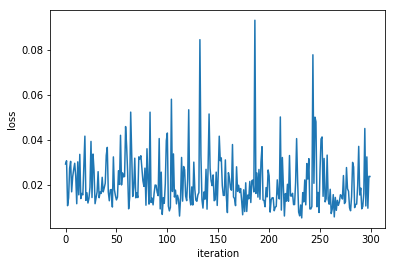

In [28]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


### Find the misclassified samples 

In [30]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
    # end if
# end for

Sample : 424; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 875; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 1265; Expected Label: tensor([0]); Obtained Label: tensor([1])
Sample : 1629; Expected Label: tensor([0]); Obtained Label: tensor([1])


Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.